In [1]:
from tqdm import tqdm
import numpy as np
from dataclasses import dataclass
import torch
import torch.nn as nn
import os
@dataclass
class BaseConfig():
    device = "cuda"
    DATASET = "MNIST"  #  "MNIST", "Cifar-10", "Flowers"
 
    # For logging inferece images and saving checkpoints.
    root_log_dir = os.path.join("Logs_Checkpoints", "Inference")
    root_checkpoint_dir = os.path.join("Logs_Checkpoints", "checkpoints")
 
    # Current log and checkpoint directory.
    log_dir = "version_0"
    checkpoint_dir = "version_0"
 
@dataclass
class TrainingConfig():
    TIMESTEPS = 1000  # Define number of diffusion timesteps
    IMG_SHAPE = (1, 32, 32)
    NUM_EPOCHS = 800
    BATCH_SIZE = 32
    LR = 0.0005
    NUM_WORKERS = 2

In [2]:
import torchvision
import torchvision.transforms as TF
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
 
def get_dataset(dataset_name='MNIST'):
    transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize((32, 32), 
                                          interpolation=torchvision.transforms.InterpolationMode.BICUBIC, 
                                          antialias=True),
            torchvision.transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
        ]
    )
     
    if dataset_name.upper() == "MNIST":
        dataset = datasets.MNIST(root="data", train=True, download=True, transform=transforms)
    elif dataset_name == "Cifar-10":    
        dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms)
    elif dataset_name == "Cifar-100":
        dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms)
    elif dataset_name == "Flowers":
        dataset = datasets.ImageFolder(root="/kaggle/input/flowers-recognition/flowers", transform=transforms)
 
    return dataset
 
def inverse_transform(tensors):
    """Convert tensors from [-1., 1.] to [0., 255.]"""
    return ((tensors.clamp(-1, 1) + 1.0) / 2.0) * 255.0

/home/viktor1234/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from MyUtils import DeviceDataLoader

def get_dataloader(dataset_name='MNIST', 
                   batch_size=32, 
                   pin_memory=False, 
                   shuffle=True, 
                   num_workers=0, 
                   device="cpu"
                  ):
    dataset      = get_dataset(dataset_name=dataset_name)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            pin_memory=pin_memory, 
                            num_workers=num_workers, 
                            shuffle=shuffle
                           )
    # Used for moving batch of data to the user-specified machine: cpu or gpu
    dataloader = DeviceDataLoader(dataloader,device)
    return dataloader

In [4]:
loader = get_dataloader(
    dataset_name=BaseConfig.DATASET,
    batch_size=128,
    device=BaseConfig.device,
)

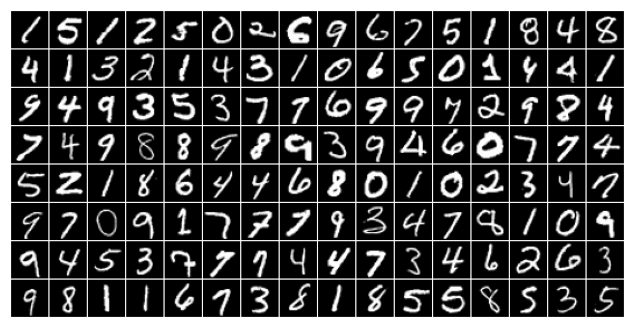

In [5]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4), facecolor='white')
 
for b_image, _ in loader:
    b_image = inverse_transform(b_image)
    grid_img = make_grid(b_image / 255.0, nrow=16, padding=True, pad_value=1)
    plt.imshow(grid_img.cpu().permute(1, 2, 0))
    plt.axis("off")
    break

In [6]:
from DiffusionFuncs import SimpleDiffusion, forward_diffusion, get

sd = SimpleDiffusion(num_diffusion_timesteps=TrainingConfig.TIMESTEPS, device=BaseConfig.device)
 
loader = iter(  # converting dataloader into an iterator for now.
    get_dataloader(
        dataset_name=BaseConfig.DATASET,
        batch_size=6,
        device=BaseConfig.device,
    )
)

In [7]:
x0s, _ = next(loader)
x0s = x0s.to(BaseConfig.device)
noisy_images = []
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]
 
for timestep in specific_timesteps:
    timestep = torch.as_tensor(timestep, dtype=torch.long, device=BaseConfig.device)
 
    xts, _ = forward_diffusion(sd, x0s, timestep)
    xts    = inverse_transform(xts) / 255.0
    xts    = make_grid(xts, nrow=1, padding=1)
     
    noisy_images.append(xts)

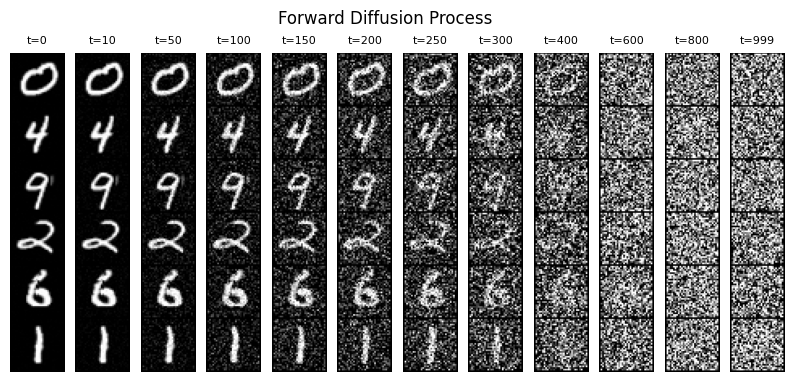

In [8]:
_, ax = plt.subplots(1, len(noisy_images), figsize=(10, 5), facecolor='white')

for i, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images)):
    ax[i].imshow(noisy_sample.squeeze(0).permute(1, 2, 0).cpu())
    ax[i].set_title(f"t={timestep}", fontsize=8)
    ax[i].axis("off")
    ax[i].grid(False)
 
plt.suptitle("Forward Diffusion Process", y=0.9)
plt.axis("off")
plt.show()

In [9]:
modelType = "UNetSimple" # Anything else

In [10]:
# Algorithm 1: Training

def train_one_epoch(model, loader, sd, optimizer, loss_fn, epoch=800, 
                   base_config=BaseConfig(), training_config=TrainingConfig()):
     
    loss_record = []
    model.train()
 
    with tqdm(total=len(loader), dynamic_ncols=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch}/{training_config.NUM_EPOCHS}")
          
        for x0s, _ in loader:
            optimizer.zero_grad()

            tq.update(1)
            ts = torch.randint(low=1, high=training_config.TIMESTEPS, size=(x0s.shape[0],), device=base_config.device)
            xts, gt_noise = forward_diffusion(sd, x0s, ts)
            if (modelType == "NSDE"):
                m = xts[:, 0, :].to(model.device)
                P = torch.eye(model.len, device=model.device).expand(training_config.BATCH_SIZE, model.len,model.len)*1e-6
                pred_noise, P = model.next_moments(m,P)
            elif (modelType == "UNetNSDE"):
                m = xts
                y = torch.ones_like(xts)*(-1e-6)
                pred_noise, p = model(m, y)
            elif (modelType == "UNetNSDEFULL"):
                m = xts
                y = torch.ones_like(xts)*(-1e-6)
                pred_noise, p = model(m, y)
            elif (modelType == "UNetNSDEMid"):
                m = xts
                pred_noise, p = model(m, ts)
            elif (modelType == "UNetSimple"):
                m = xts
                pred_noise = model(m,ts)
            elif (modelType == "UNetATT"):
                m = xts
                pred_noise = model(m, ts)
            else:
                pred_noise = model.next_moments(xts,ts)
            loss = loss_fn(gt_noise, pred_noise)
            loss.backward()
            optimizer.step()
            loss_value = loss.detach().item()
            loss_record.append(loss_value)
 
            tq.set_postfix_str(s=f"Loss: {loss_value:.4f}")
 
        mean_loss = np.mean(loss_record)
        print(pred_noise[0][0][0][0], gt_noise[0][0][0][0])

        tq.set_postfix_str(s=f"Epoch Loss: {mean_loss:.4f}")
     
    return mean_loss

In [11]:
# Algorithm 2: Sampling
     
@torch.no_grad()
def reverse_diffusion(model, sd, timesteps=1000, img_shape=(3, 64, 64), 
                      num_images=5, nrow=8, device="cpu", **kwargs):
 
    x = torch.randn((num_images, *img_shape), device=device)
    
    model.eval()
 
    for time_step in tqdm(iterable=reversed(range(1, timesteps)), 
                          total=timesteps-1, dynamic_ncols=False, 
                          desc="Sampling :: ", position=0):
 
        ts = torch.ones(num_images, dtype=torch.long, device=device) * time_step
        z = torch.randn_like(x) if time_step > 1 else torch.zeros_like(x)
        if (modelType == "NSDE"):
            m = x[:, 0, :].to(BaseConfig.device)
            P = torch.eye(model.len, device=model.device).expand(1, model.len,model.len)*1e-6
            predicted_noise, p = model.next_moments(m,P)
        elif (modelType == "UNetNSDE"):
            y = torch.ones_like(x)*(1e-6)
            predicted_noise, p = model(x,y)
        elif (modelType == "UNetNSDEFULL"):
                y = torch.ones_like(xts)*(-1e-6)
                predicted_noise, p = model(x, y)
        elif (modelType == "UNetNSDEMid"):
            predicted_noise, p = model(x,ts)
        elif (modelType == "UNetSimple"):
            predicted_noise = model(x,ts)
        elif (modelType == "UNetATT"):
            predicted_noise = model(x, ts)
        else:
            predicted_noise = model(x,ts)
        beta_t = get(sd.beta, ts)
        one_by_sqrt_alpha_t = get(sd.one_by_sqrt_alpha, ts)
        sqrt_one_minus_alpha_cumulative_t = get(sd.sqrt_one_minus_alpha_cumulative, ts) 
        x = (
            one_by_sqrt_alpha_t
            * (x - (beta_t / sqrt_one_minus_alpha_cumulative_t) * predicted_noise)
            + torch.sqrt(beta_t) * z
        )
 
    # Display and save the image at the final timestep of the reverse process. 
    x = inverse_transform(x).type(torch.uint8)
    grid = make_grid(x, nrow=nrow, pad_value=255.0).to("cpu")
    pil_image = TF.functional.to_pil_image(grid)
    pil_image.save(kwargs["save_path"])
    display(pil_image)
    return None

In [12]:
from Models.UNetClosed import UNetNSDE, UNetSimple, ConvNSDE, UNetNSDE2, UNetNSDEMid
from Models.UNetATT import UNetATT
from Models.LLM import DiffusionNSDE, LinearDiffusion

In [13]:
@dataclass
class ModelConfig:
    BASE_CH = 16  # 64, 128, 256, 256
    BASE_CH_MULT = (1, 2, 4, 8) # 32, 16, 8, 4 
    APPLY_ATTENTION = (False, False, True, False)
    DROPOUT_RATE = 0.1
    TIME_EMB_MULT = 2 # 128
    DEVICE = BaseConfig.device

if(modelType =="NSDE"):    
    model = DiffusionNSDE(d=TrainingConfig.IMG_SHAPE[-1]**2, n_hidden=2*TrainingConfig.IMG_SHAPE[-1]**2, device=ModelConfig.DEVICE)
elif(modelType =="UNetNSDE"):
    model = UNetNSDE(TrainingConfig.IMG_SHAPE[0])
elif(modelType =="UNetNSDEFULL"):
    model = UNetNSDE2(TrainingConfig.IMG_SHAPE[0])
elif(modelType =="UNetNSDEMid"):
    model = UNetNSDEMid(TrainingConfig.IMG_SHAPE[0])
elif(modelType =="UNetSimple"):
    model = UNetSimple(TrainingConfig.IMG_SHAPE[0])
elif(modelType =="UNetATT"):
    model = UNetATT(
    input_channels          = TrainingConfig.IMG_SHAPE[0],
    output_channels         = TrainingConfig.IMG_SHAPE[0],
    base_channels           = ModelConfig.BASE_CH,
    base_channels_multiples = ModelConfig.BASE_CH_MULT,
    apply_attention         = ModelConfig.APPLY_ATTENTION,
    dropout_rate            = ModelConfig.DROPOUT_RATE,
    time_multiple           = ModelConfig.TIME_EMB_MULT,
)
else:
    model = LinearDiffusion(image_h=TrainingConfig.IMG_SHAPE[-1], device=ModelConfig.DEVICE, num_layers=3)

model.to(ModelConfig.DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=TrainingConfig.LR) # Original → Adam

dataloader = get_dataloader(
    dataset_name  = BaseConfig.DATASET,
    batch_size    = TrainingConfig.BATCH_SIZE,
    device        = BaseConfig.device,
    pin_memory    = True,
    num_workers   = TrainingConfig.NUM_WORKERS,
)
 
loss_fn = nn.MSELoss()
 
sd = SimpleDiffusion(
    num_diffusion_timesteps = TrainingConfig.TIMESTEPS,
    img_shape               = TrainingConfig.IMG_SHAPE,
    device                  = BaseConfig.device,
)
 
# scaler = amp.GradScaler() # For mixed-precision training.

In [14]:
from MyUtils import setup_log_directory

total_epochs = TrainingConfig.NUM_EPOCHS + 1
log_dir, checkpoint_dir = setup_log_directory(config=BaseConfig())
ext = ".png"

Logging at: Logs_Checkpoints/Inference/version_23
Model Checkpoint at: Logs_Checkpoints/checkpoints/version_23


Train :: Epoch: 1/800: 100%|██████████| 1875/1875 [02:54<00:00, 10.77it/s, Epoch Loss: 0.0734]


tensor(-0.0330, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0329, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:15<00:00, 65.33it/s]


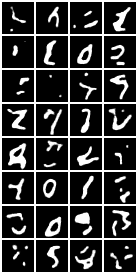

Train :: Epoch: 2/800: 100%|██████████| 1875/1875 [02:50<00:00, 11.02it/s, Epoch Loss: 0.0415]


tensor(-1.1662, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-1.0469, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:10<00:00, 91.50it/s]


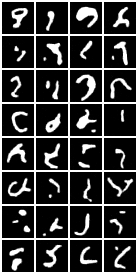

Train :: Epoch: 3/800: 100%|██████████| 1875/1875 [02:39<00:00, 11.78it/s, Epoch Loss: 0.0369]


tensor(0.3312, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3989, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:12<00:00, 77.25it/s]


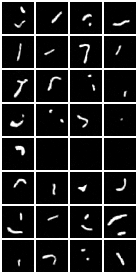

Train :: Epoch: 4/800: 100%|██████████| 1875/1875 [02:40<00:00, 11.67it/s, Epoch Loss: 0.0336]


tensor(0.6035, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5920, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:13<00:00, 73.71it/s]


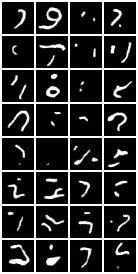

Train :: Epoch: 5/800: 100%|██████████| 1875/1875 [02:42<00:00, 11.55it/s, Epoch Loss: 0.0318]


tensor(0.3703, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3388, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:13<00:00, 76.38it/s]


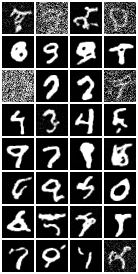

Train :: Epoch: 6/800: 100%|██████████| 1875/1875 [02:43<00:00, 11.49it/s, Epoch Loss: 0.0306]


tensor(-0.4611, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-0.4314, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:12<00:00, 83.14it/s]


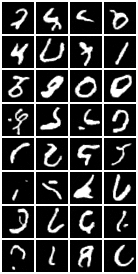

Train :: Epoch: 7/800: 100%|██████████| 1875/1875 [02:39<00:00, 11.73it/s, Epoch Loss: 0.0300]


tensor(0.6713, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5469, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:12<00:00, 78.17it/s]


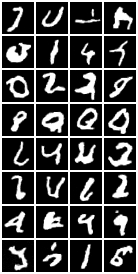

Train :: Epoch: 8/800: 100%|██████████| 1875/1875 [02:37<00:00, 11.94it/s, Epoch Loss: 0.0283]


tensor(1.3211, device='cuda:0', grad_fn=<SelectBackward0>) tensor(1.3375, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:13<00:00, 73.68it/s]


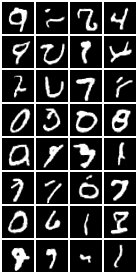

Train :: Epoch: 9/800: 100%|██████████| 1875/1875 [03:05<00:00, 10.13it/s, Epoch Loss: 0.0278]


tensor(-1.0687, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-1.1726, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:13<00:00, 73.51it/s]


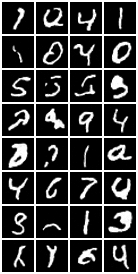

Train :: Epoch: 10/800: 100%|██████████| 1875/1875 [02:40<00:00, 11.71it/s, Epoch Loss: 0.0268]


tensor(-0.2450, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-0.1585, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:12<00:00, 78.46it/s]


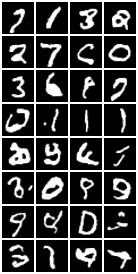

Train :: Epoch: 11/800: 100%|██████████| 1875/1875 [02:36<00:00, 12.00it/s, Epoch Loss: 0.0265]


tensor(0.4061, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3520, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:13<00:00, 75.97it/s]


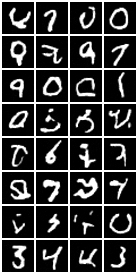

Train :: Epoch: 12/800: 100%|██████████| 1875/1875 [02:44<00:00, 11.41it/s, Epoch Loss: 0.0259]


tensor(-0.5958, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-0.5057, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:13<00:00, 72.07it/s]


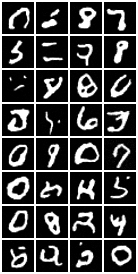

Train :: Epoch: 13/800: 100%|██████████| 1875/1875 [02:52<00:00, 10.87it/s, Epoch Loss: 0.0256]


tensor(0.0087, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-0.0184, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:13<00:00, 71.61it/s]


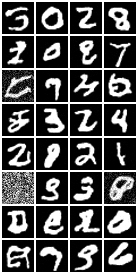

Train :: Epoch: 14/800: 100%|██████████| 1875/1875 [02:51<00:00, 10.96it/s, Epoch Loss: 0.0252]


tensor(0.0421, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-0.0034, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:14<00:00, 70.13it/s]


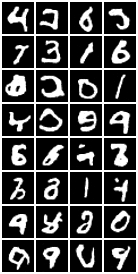

Train :: Epoch: 15/800: 100%|██████████| 1875/1875 [02:48<00:00, 11.12it/s, Epoch Loss: 0.0249]


tensor(-0.7416, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-0.7054, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:14<00:00, 70.60it/s]


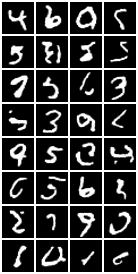

Train :: Epoch: 16/800: 100%|██████████| 1875/1875 [02:49<00:00, 11.06it/s, Epoch Loss: 0.0248]


tensor(0.0754, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0335, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:13<00:00, 72.54it/s]


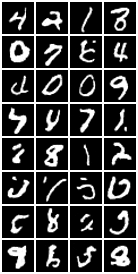

Train :: Epoch: 17/800: 100%|██████████| 1875/1875 [02:47<00:00, 11.20it/s, Epoch Loss: 0.0244]


tensor(-0.9696, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-0.9943, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:13<00:00, 72.30it/s]


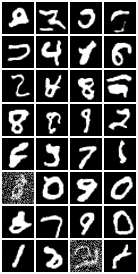

Train :: Epoch: 18/800: 100%|██████████| 1875/1875 [02:50<00:00, 10.99it/s, Epoch Loss: 0.0243]


tensor(-1.7219, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-1.6906, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:13<00:00, 72.48it/s]


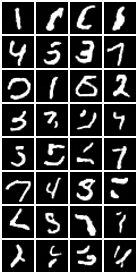

Train :: Epoch: 19/800: 100%|██████████| 1875/1875 [02:43<00:00, 11.49it/s, Epoch Loss: 0.0241]


tensor(1.2783, device='cuda:0', grad_fn=<SelectBackward0>) tensor(1.1730, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:12<00:00, 78.63it/s]


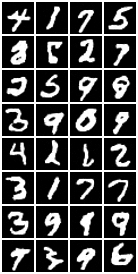

Train :: Epoch: 20/800: 100%|██████████| 1875/1875 [02:52<00:00, 10.87it/s, Epoch Loss: 0.0240]


tensor(-0.1351, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-0.1619, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:14<00:00, 71.33it/s]


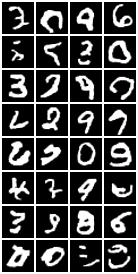

Train :: Epoch: 21/800: 100%|██████████| 1875/1875 [02:46<00:00, 11.24it/s, Epoch Loss: 0.0243]


tensor(0.6416, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.7420, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:14<00:00, 69.62it/s]


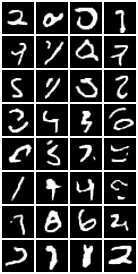

Train :: Epoch: 22/800: 100%|██████████| 1875/1875 [02:46<00:00, 11.28it/s, Epoch Loss: 0.0238]


tensor(-0.7368, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-0.8146, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:13<00:00, 72.65it/s]


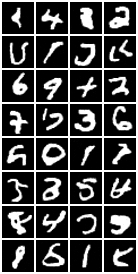

Train :: Epoch: 23/800: 100%|██████████| 1875/1875 [02:47<00:00, 11.22it/s, Epoch Loss: 0.0238]


tensor(-0.3118, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-0.2472, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:14<00:00, 71.08it/s]


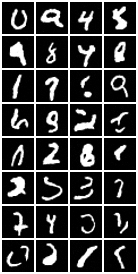

Train :: Epoch: 24/800: 100%|██████████| 1875/1875 [02:44<00:00, 11.42it/s, Epoch Loss: 0.0235]


tensor(-0.8803, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-0.8624, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:12<00:00, 78.52it/s]


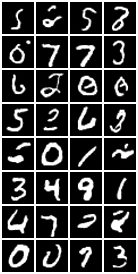

Train :: Epoch: 25/800: 100%|██████████| 1875/1875 [02:41<00:00, 11.62it/s, Epoch Loss: 0.0234]


tensor(-1.2551, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-1.0404, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:12<00:00, 78.37it/s]


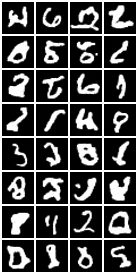

Train :: Epoch: 26/800: 100%|██████████| 1875/1875 [02:52<00:00, 10.88it/s, Epoch Loss: 0.0234]


tensor(0.7266, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.7611, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:12<00:00, 83.18it/s]


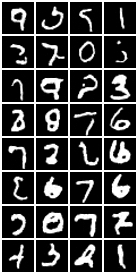

Train :: Epoch: 27/800: 100%|██████████| 1875/1875 [02:46<00:00, 11.23it/s, Epoch Loss: 0.0231]


tensor(1.3834, device='cuda:0', grad_fn=<SelectBackward0>) tensor(1.3039, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:13<00:00, 74.37it/s]


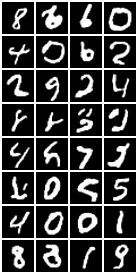

Train :: Epoch: 28/800: 100%|██████████| 1875/1875 [02:45<00:00, 11.36it/s, Epoch Loss: 0.0230]


tensor(-2.6419, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-2.6085, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:13<00:00, 76.76it/s]


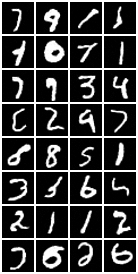

Train :: Epoch: 29/800: 100%|██████████| 1875/1875 [02:57<00:00, 10.56it/s, Epoch Loss: 0.0233]


tensor(0.4317, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4497, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:14<00:00, 68.55it/s]


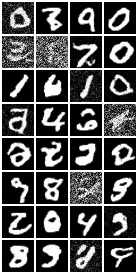

Train :: Epoch: 30/800: 100%|██████████| 1875/1875 [02:51<00:00, 10.92it/s, Epoch Loss: 0.0229]


tensor(-0.0508, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-0.0033, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:11<00:00, 83.50it/s]


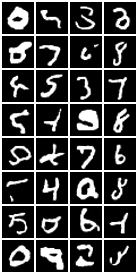

Train :: Epoch: 31/800: 100%|██████████| 1875/1875 [02:47<00:00, 11.17it/s, Epoch Loss: 0.0228]


tensor(-1.0398, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-0.9524, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:13<00:00, 74.52it/s]


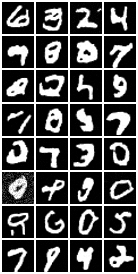

Train :: Epoch: 32/800: 100%|██████████| 1875/1875 [02:47<00:00, 11.18it/s, Epoch Loss: 0.0228]


tensor(2.4214, device='cuda:0', grad_fn=<SelectBackward0>) tensor(2.4661, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:13<00:00, 72.97it/s]


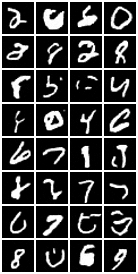

Train :: Epoch: 33/800: 100%|██████████| 1875/1875 [02:55<00:00, 10.70it/s, Epoch Loss: 0.0227]


tensor(-0.6538, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-0.4655, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:13<00:00, 76.75it/s]


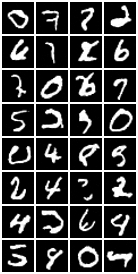

Train :: Epoch: 34/800: 100%|██████████| 1875/1875 [03:02<00:00, 10.25it/s, Epoch Loss: 0.0226]


tensor(-0.2942, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-0.2898, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:14<00:00, 68.06it/s]


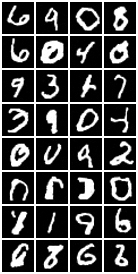

Train :: Epoch: 35/800: 100%|██████████| 1875/1875 [02:51<00:00, 10.94it/s, Epoch Loss: 0.0228]


tensor(0.0423, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1568, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:13<00:00, 72.63it/s]


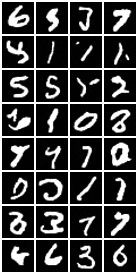

Train :: Epoch: 36/800: 100%|██████████| 1875/1875 [02:42<00:00, 11.53it/s, Epoch Loss: 0.0227]


tensor(-0.7906, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-0.8198, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:14<00:00, 67.76it/s]


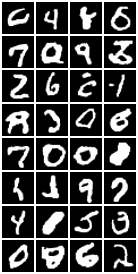

Train :: Epoch: 37/800: 100%|██████████| 1875/1875 [02:55<00:00, 10.69it/s, Epoch Loss: 0.0223]


tensor(-1.1609, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-1.1655, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:14<00:00, 71.25it/s]


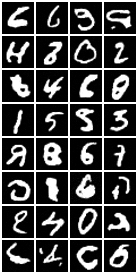

Train :: Epoch: 38/800: 100%|██████████| 1875/1875 [02:51<00:00, 10.96it/s, Epoch Loss: 0.0223]


tensor(0.1437, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1138, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:14<00:00, 70.19it/s]


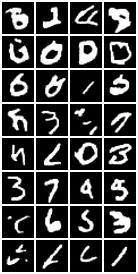

Train :: Epoch: 39/800: 100%|██████████| 1875/1875 [02:52<00:00, 10.85it/s, Epoch Loss: 0.0226]


tensor(-0.3826, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-0.3216, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:13<00:00, 73.03it/s]


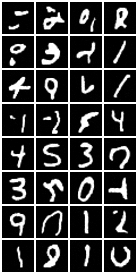

Train :: Epoch: 40/800: 100%|██████████| 1875/1875 [02:49<00:00, 11.09it/s, Epoch Loss: 0.0226]


tensor(-0.3040, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-0.1934, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:14<00:00, 69.15it/s]


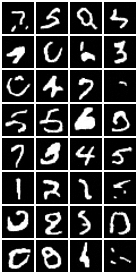

Train :: Epoch: 41/800: 100%|██████████| 1875/1875 [02:53<00:00, 10.83it/s, Epoch Loss: 0.0224]


tensor(-1.8079, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-1.8652, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:14<00:00, 69.97it/s]


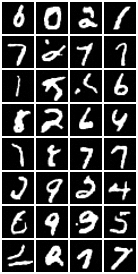

Train :: Epoch: 42/800: 100%|██████████| 1875/1875 [02:56<00:00, 10.61it/s, Epoch Loss: 0.0226]


tensor(0.3500, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2732, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:14<00:00, 71.08it/s]


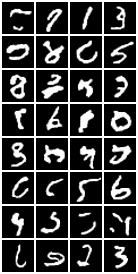

Train :: Epoch: 43/800: 100%|██████████| 1875/1875 [02:47<00:00, 11.19it/s, Epoch Loss: 0.0224]


tensor(-0.6716, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-0.7059, device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:13<00:00, 74.50it/s]


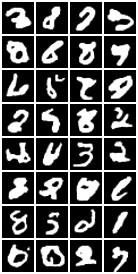

Train :: Epoch: 44/800:  45%|████▌     | 844/1875 [01:15<01:31, 11.23it/s, Loss: 0.0273]


KeyboardInterrupt: 

In [15]:
import gc
torch.autograd.set_detect_anomaly(True)
for epoch in range(1, total_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    
    # Algorithm 1: Training
    train_one_epoch(model, dataloader, sd, optimizer, loss_fn, epoch=epoch)
 
    if epoch % 1 == 0:
        save_path = os.path.join(log_dir, f"{epoch}{ext}")
         
        # Algorithm 2: Sampling
        reverse_diffusion(model, sd, timesteps=TrainingConfig.TIMESTEPS, 
                          num_images=32, save_path=save_path, 
                          img_shape=TrainingConfig.IMG_SHAPE, device=BaseConfig.device, nrow=4,
        )
 
        # clear_output()
        checkpoint_dict = {
            "opt": optimizer.state_dict(),
            "model": model.state_dict()
        }
        torch.save(checkpoint_dict, os.path.join(checkpoint_dir, "ckpt.pt"))
        del checkpoint_dict

Sampling :: 100%|██████████| 999/999 [00:59<00:00, 16.66it/s]


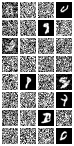

In [ ]:
reverse_diffusion(model, sd, timesteps=TrainingConfig.TIMESTEPS, 
                          num_images=32, save_path="./samples/Test.png", 
                          img_shape=TrainingConfig.IMG_SHAPE, device=BaseConfig.device, nrow=4,
        )